In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier


In [20]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head
df.dtypes
# df.select_dtypes('object').nunique()

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [21]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
X = df.drop('stroke', axis=1)
y = pd.DataFrame(df['stroke'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)


In [18]:
preprocessing = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), list(df.select_dtypes('object'))),
    remainder='passthrough'
)

model = XGBClassifier()

pipeline = make_pipeline(
    preprocessing,
    model
)

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid, preds)}')

accuracy: 0.9478147423352903


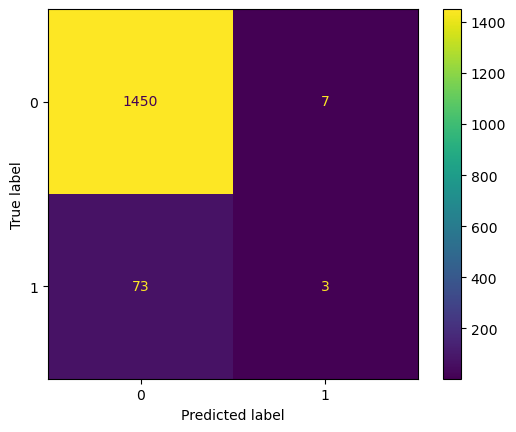

In [19]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [60]:
from pydantic import BaseModel, ValidationError

class Symptoms(BaseModel):
    id: int
    gender: object
    age: float
    hypertension: int
    heart_disease: int
    ever_married: object
    work_type: object
    Residence_type: object
    avg_glucose_level: float
    bmi: float
    smoking_status: object


In [46]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        symptoms = Symptoms(**request.json)
        inputs = pd.DataFrame([symptoms.model_dump()])
        # print(inputs)
        pred = pipeline.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Oct/2024 13:40:49] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [08/Oct/2024 13:41:00] "POST /predict HTTP/1.1" 200 -


{"id":1,"gender":"Male","age":1.0,"hypertension":1,"heart_disease":1,"ever_married":"Yes","work_type":"Private","Residence_type":"Urban","avg_glucose_level":1.0,"bmi":1.0,"smoking_status":"smoked"}
